<a href="https://colab.research.google.com/github/majidraeis/RL_for_Queueing/blob/master/QueueLearning(Average_Backlog).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Admission Control in Multi-server Queueing System

Consider a multi-server queueing system with $c$ servers. We want to learn an admission control policy that stabilizes the queue such that the average backlog converges to some given value (e.g. $B_{th}$).
## Goal:
Find $\pi$ such that $E_{\pi}[b(t)]\to B_{th}$,
where $b(t)$ denotes the backlog at time $t$.

## State ($s$):
Number of jobs in the system (queue+servers)
## Actions ($a$):
Accept or Reject the incoming job
## Reward ($R(s,a)$):
$b$ denotes backlog ($b = \max(s - c, 0 )$) 
>
$
\begin{equation*}
r_1 = \left\{
\begin{array}{ll}
1,  \qquad & b <B_{th}\\ 
-1,  \qquad & b >B_{th}
\end{array} \right.
\end{equation*}
\qquad$
$
\begin{equation*}
r_2 = \left\{
\begin{array}{ll}
1,  \qquad & a = Accept\\ 
-1,  \qquad & a = Reject
\end{array} \right.
\end{equation*}
$

> $R(s,a) = r_1.r_2$

<img src="https://raw.githubusercontent.com/majidraeis/Figs/master/queue_demo.gif" width="600" height="400" />

In [0]:
import os
from gym import spaces
import gym
import random
import tkinter as tk
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import style
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
style.use("ggplot")
customer_color = '#191970'
line_color = '#00BFFF'
np.random.seed(10)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Environment

In [0]:
class QueueEnv(gym.Env):
    """
    Define a multi-server queue.
    The environment defines the admission control problem in a multi-server queue.
    Action: accept(1) or reject(0), State: 1- # of jobs in the system 2- time average estimate of P(b>b_th) up to now
    """

    def __init__(self, n_s, rho, mu_s, b_th):
        # --------------------self.__version__ = "0.1.0"------------------------
        #----------- General variables defining the environment-----------------
        self.n_servers = n_s
        self.rho = rho
        self.n_jobs = 0
        self.ql_vec = [0]
        self.t_arr = 0  # First arrival time is 0 by default
        self.mu_s = mu_s
        self.t_vec = [0.0]
        self.render_initiate = False
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Discrete(1000)
        self.empty_servers = np.arange(n_s)
        self.assigned_servers = []
        self.t_fin = []
        self.job_dict = {}
        self.job_dict[0] = {'Tw': 0.0}
        self.accepted_job_ind_vec = []
        self.waiting_vec = []
        self.job_index = 1
        self.last_entered_job = 0
        self.batch_size = 0
        self.cnt = 1
        self.MAX_STEPS = 10**4
        self.b_th = b_th
        self.P_est = 0

    def step(self, action):
        """
        The agent takes a step in the environment.
        Parameters
        ----------
        action : int
        Returns
        -------
        ob, reward, episode_over, info : tuple
            ob (object) :
                an environment-specific object representing your observation of
                the environment.
            reward (float) :
                amount of reward achieved by the previous action. The scale
                varies between environments, but the goal is always to increase
                your total reward.
            episode_over (bool) :
                whether it's time to reset the environment again. Most (but not
                all) tasks are divided up into well-defined episodes, and done
                being True indicates the episode has terminated. (For example,
                perhaps the pole tipped too far, or you lost your last life.)
            info (dict) :
                 diagnostic information useful for debugging. It can sometimes
                 be useful for learning (for example, it might contain the raw
                 probabilities behind the environment's last state change).
                 However, official evaluations of your agent are not allowed to
                 use this for learning.
        """
        self._take_action(action)
        reward = self._get_reward(action)
        self.P_est += (int(max(self.n_jobs - self.n_servers, 0)>self.b_th) \
                       - self.P_est)/self.cnt
        ob = (self.n_jobs, self.P_est)
        done = False if self.cnt < self.MAX_STEPS else True
        self.cnt += 1
        return ob, reward, done, {}


    def _take_action(self, action):
        # -----Queue length before taking the action (upon job arrival)---------
        self.ql = max(self.n_jobs - self.n_servers, 0)  
        if action:

            for _ in range(self.batch_size):

                if self.n_jobs < self.n_servers:
                    t_ent = self.t_arr
                    self.empty_servers = [x for x in range(self.n_servers) if x not in self.assigned_servers]
                    self.assigned_servers = np.append(self.assigned_servers, random.choice(self.empty_servers))

                else:
                    # ---finding the time that each server gets empty-----------
                    t_available = [np.max(self.t_fin[self.assigned_servers == i]) for i in range(self.n_servers)]
                    
                    # --------pick the earliest server available----------------
                    picked_server = np.argmin(t_available)
                    t_ent = max(self.t_arr, t_available[picked_server])
                    self.assigned_servers = np.append(self.assigned_servers, picked_server)

                t_s = self._service_gen()
                self.t_fin = np.append(self.t_fin, t_ent + t_s)
                # **********************************
                self.job_dict[self.job_index] = {'Ta': self.t_arr, 'Td': t_ent + t_s, 'Ts': t_s, 'Tw': t_ent-self.t_arr,
                                                 'Ba': self.ql}
                # **********************************
                self.last_entered_job = self.job_index
                self.job_index += 1
                self.n_jobs += 1

        self.last_t_arr = self.t_arr
        self.t_arr += 1
        served_jobs_ind = np.arange(len(self.t_fin))[np.array(self.t_fin) <= self.t_arr]
        if len(np.array(env.t_fin) < env.t_arr):
            self.last_t_fins = self.t_fin[np.array(self.t_fin) <= self.t_arr]
        else:
            self.last_t_fins = []
        self.n_jobs -= np.sum(np.array(self.t_fin) <= self.t_arr)
        self.t_fin = np.delete(self.t_fin, served_jobs_ind)
        self.assigned_servers = np.delete(self.assigned_servers, served_jobs_ind)


    def _batch_gen(self):
        lambda_a = self.n_servers * self.rho * self.mu_s
        if np.random.rand(1)<lambda_a:
          return 1
        else:
          return 0

    def _service_gen(self):
        return np.random.geometric(p=self.mu_s)

    def _get_reward(self, action):
        "queue length after taking the action"
        self.ql = max(self.n_jobs - self.n_servers, 0)
        r = 1 if self.ql <= self.b_th else -1
        return r * (2*action-1)

    def reset(self):
        """
        Reset the state of the environment and returns an initial observation.
        Returns
        ----------------------------------------------------------
        observation (object): the initial observation of the space.
        """
        self.ql_vec = [0]
        self.n_jobs = 0
        self.t_arr = 0  # First arrival time is 0 by default
        self.t_arr = 0
        self.t_vec = [0]
        self.empty_servers = np.arange(self.n_servers)
        self.assigned_servers = []
        self.t_fin = []
        self.job_dict = {}
        self.job_index = 1
        self.accepted_job_ind_vec = []
        self.waiting_vec = []
        self.job_dict[0] = {'Tw': 0.0}
        self.last_entered_job = 0
        self.cnt = 1
        self.rej_cost = 1
        self.P_est = 0
        return (self.n_jobs, self.P_est)

    def _text(self):
        text = "QL = %d" % self.ql
        self.canvas.itemconfig(self.text, text=text)
        self.canvas.update

    def render(self, mode='human', close=False):  # rendering the queue after taking the action

        self._Queue_plot()
        self._QL_plot()
        self._waiting_plot()
        self._text()
        return

    def _Queue_plot(self):

        num_busy_servers = max(self.n_jobs - self.ql, 0)
        qHead = 300
        qTail = 150
        p2qDist = 2
        c2cDist = 4
        shift_up = 70
        cirR_o = 25  # Server circle outer radius
        cirR_i = 22  # Server circle inner radius
        cirC = [335, 200]
        linewidth = 2
        cirC[1] = cirC[1] - ((self.n_servers - 1) * cirR_o + (self.n_servers - 1) * c2cDist / 2)

        if self.render_initiate:
            self.root = tk.Tk()
            self.canvas = tk.Canvas(self.root, width=550, height=250)
            self.root.title('Queueing')
            self.canvas.pack()
            self.inner_circle = []
            self.canvas.create_line(qTail, 175-shift_up, qHead, 175-shift_up, width=linewidth, fill=line_color)
            self.canvas.create_line(qTail, 225-shift_up, qHead, 225-shift_up, width=linewidth, fill=line_color)
            self.canvas.create_line(qHead, 175-shift_up, qHead, 225-shift_up, width=linewidth, fill=line_color)
            for c in range(self.n_servers):
                self.canvas.create_oval(cirC[0] - cirR_o, cirC[1] - cirR_o-shift_up, cirC[0] + cirR_o,
                                        cirC[1] + cirR_o-shift_up, outline=line_color, width=linewidth)
                self.inner_circle.append(self.canvas.create_oval(cirC[0] - cirR_i, cirC[1] - cirR_i-shift_up, cirC[0]
                                         + cirR_i, cirC[1] + cirR_i-shift_up, outline='white',
                                         fill='white', width=linewidth))
                cirC[1] = cirC[1] + c2cDist + 2 * cirR_o
            self.queue_len = self.canvas.create_rectangle(qHead - p2qDist-p2qDist, 180-shift_up, qHead - p2qDist-p2qDist
                                                          , 220-shift_up, fill=customer_color)

            self.text = self.canvas.create_text((qTail+qHead)/2, 166-shift_up, fill="black", text="Queue length = 0")
        else:

            self.canvas.coords(self.queue_len, qHead - p2qDist-p2qDist - self.ql * 5, 180-shift_up,
                               qHead - p2qDist-p2qDist, 220-shift_up)

            for c in range(self.n_servers):
                if c+1 <= num_busy_servers:
                    self.canvas.itemconfig(self.inner_circle[c], fill=customer_color)
                    self.canvas.update()

                else:
                    self.canvas.itemconfig(self.inner_circle[c], fill='white', width=linewidth)
                    self.canvas.update()

                cirC[1] = cirC[1] + c2cDist + 2 * cirR_o

    def _QL_plot(self):
        # ----------------After taking the action----------------------
        # ------------------- Queue Length ----------------------------
        n_job_after_action = self.n_jobs + len(self.last_t_fins)
        ql_after_action = max(n_job_after_action - self.n_servers, 0)
        self.ql_vec = np.append(self.ql_vec, ql_after_action)
        self.t_vec = np.append(self.t_vec, self.last_t_arr)
        # ------------- Departures until the next arrival -------------
        ql_deps = n_job_after_action - np.arange(1, len(self.last_t_fins)+1)
        ql_deps = (ql_deps - self.n_servers) * (ql_deps - self.n_servers > 0)
        self.ql_vec = np.append(self.ql_vec, ql_deps)
        self.t_vec = np.append(self.t_vec, np.sort(self.last_t_fins))

        if self.render_initiate:

            self.figure1 = Figure(figsize=(5, 4))
            self.subplot1 = self.figure1.add_subplot(111)
            # Queue length after taking the action
            self.subplot1.step(self.t_vec, self.ql_vec, where='post', color='lightsteelblue')
            self.plot1 = FigureCanvasTkAgg(self.figure1, self.root)
            self.plot1.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH, expand=1)
            self.subplot1.set_xlabel('Time')
            self.subplot1.set_ylabel('Queue length')
        else:

            self.subplot1.clear()
            self.subplot1.step(self.t_vec, self.ql_vec, where='post', color='tab:blue')
            self.figure1.canvas.draw_idle()
            self.subplot1.set_xlabel('Time')
            self.subplot1.set_ylabel('Queue length')

    def _waiting_plot(self):
        # ---------------------- Waiting time ----------------------
        if self.render_initiate:

            self.accepted_job_ind_vec.append(self.last_entered_job)
            self.waiting_vec.append(self.job_dict[self.last_entered_job]['Tw'])
            self.figure2 = Figure(figsize=(5, 4))
            self.subplot2 = self.figure2.add_subplot(111)
            self.subplot2.plot(self.accepted_job_ind_vec, self.waiting_vec, color='tab:red')
            self.subplot2.set_xlabel('Job')
            self.subplot2.set_ylabel('Waiting time')
            self.plot2 = FigureCanvasTkAgg(self.figure2, env.root)
            self.plot2.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH, expand=1)
            self.render_initiate = False  # This must be run in the last plot function
        else:
            self.accepted_job_ind_vec.append(self.last_entered_job)
            self.waiting_vec.append(self.job_dict[self.last_entered_job]['Tw'])
            self.subplot2.clear()
            self.subplot2.plot(self.accepted_job_ind_vec, self.waiting_vec, color='tab:red')
            self.subplot2.set_xlabel('Job')
            self.subplot2.set_ylabel('Waiting time')
            self.figure2.canvas.draw_idle()


## Average Reward Learning for Continueing Environments

R-learning is an off-policy control method for the advanced version of the reinforcement learning problem in which one neither discounts nor divides experience into distinct episodes with finite returns. In this average-reward setting, one seeks to maximize the average reward per time step. The value functions for a policy, $\pi$, are defined relative to the average expected reward per step under the policy, $r(\pi)$:


<img src="https://raw.githubusercontent.com/majidraeis/Figs/master/R_learning.png" width="600" height="250" />




In [0]:
class Agent():
    def __init__(self, env):
        self.isCont = \
            type(env.action_space) == gym.spaces.box.Box
        if self.isCont:
            self.action_low = env.action_space.low
            self.action_high = env.action_space.high
            self.action_shape = env.action_space.shape

        else:
            self.action_size = env.action_space.n

    def get_action(self, state):
        if self.isCont:
            action = np.random.uniform(self.action_low, self.action_high, self.action_shape)
        else:
            action = random.choice(range(env.action_space.n))
        return action

"-------------------R_LEARNING-------------------"
"------------------------------------------------"
class RAgent(Agent):
    def __init__(self, env, learning_rate=0.01):
        super().__init__(env)
        self.state_size = env.observation_space.n
        self.learning_rate = learning_rate
        self.eps = 0.5
        self.beta = 0.01
        self.mean_reward = 0
        self.P_est = 0
        self.build_model()

    def build_model(self):
        self.r_table = 1 * np.random.random((env.observation_space.n, self.P_est_size, self.action_size))

    def get_action(self, state):
        n_jobs = state
        p_bins = np.linspace(0,1,self.P_est_size)
        P_est_ind = np.digitize(P_est, p_bins)-1
        r_state = self.r_table[min(n_jobs, env.observation_space.n-1), P_est_ind]
        action_greedy = np.argmax(r_state)
        action_random = super().get_action(min(n_jobs, env.observation_space.n-1))
        if random.random() < self.eps:
            self.optimal = False
            return action_random
        else:
            self.optimal = True
            return action_greedy

    def train(self, experience):
        (n_jobs, P_est), action, (next_n_jobs, next_P_est), reward, done = experience
        p_bins = np.linspace(0,1,self.P_est_size)
        P_est_ind = np.digitize(P_est, p_bins)-1
        next_P_est_ind = np.digitize(next_P_est, p_bins)-1
        r_next = self.r_table[min(next_n_jobs, env.observation_space.n-1), next_P_est_ind]
        r_next = np.zeros([self.action_size]) if done else r_next
        r_target = reward - self.mean_reward + np.max(r_next)
        r_update = r_target - self.r_table[min(n_jobs, env.observation_space.n-1), P_est_ind, action]
        self.r_table[min(n_jobs, env.observation_space.n-1), P_est_ind, action] += self.learning_rate * r_update
        if self.optimal:
            self.mean_reward = self.mean_reward + self.beta * r_update
        if done:
            self.eps *= 0.99
            self.eps = min(self.eps, 0.001)


100%|██████████| 100/100 [04:30<00:00,  2.70s/it]


Text(0, 0.5, 'Total reward')

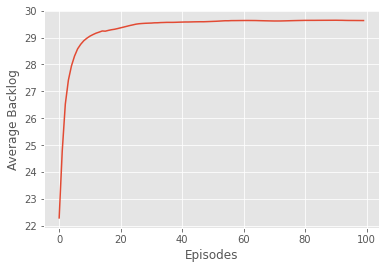

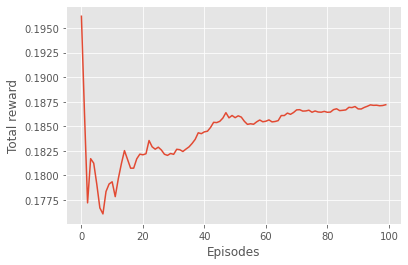

In [0]:
" -------------------Average Backlog-------------------"
"------------------------------------------------"
render_flag = False
B_th = 30
num_server = 2
ep_length = 100
env = QueueEnv(num_server, 1/(num_server*0.3), 0.3, B_th)
agent = RAgent(env)
state = env.reset()
Rej_cost = []
st = []
env.ep = 0
n_jobs = 0
done = False
cnt = 1
cnt_act = 1
cnt_time = 1
ave_reward = np.zeros(ep_length)
ql_ave = np.zeros(ep_length)

for ep in tqdm(range(ep_length)):   

  ave_reward[ep] = ave_reward[ep-1] if ep>0 else 0
  ql_ave[ep] = ql_ave[ep-1] if ep>0 else 0
  done = False
  env.cnt = 1
  while not done:
      env.batch_size = env._batch_gen()
      if not env.batch_size:
        state, _, done, info = env.step(1)
      else:
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        agent.train((state, action, next_state, reward, done))
        ave_reward[ep] += (reward - ave_reward[ep])/cnt_act
        state = next_state
        n_jobs = state
        cnt_act += 1
      ql_ave[ep] += (max(n_jobs-num_server, 0) - ql_ave[ep])/cnt_time 
      # backlog.append(max(n_jobs-num_server, 0))
      cnt_time += 1

gdrive_dir = '/content/gdrive/My Drive/Colab Notebooks/'
data_directory = gdrive_dir + 'Tables/'
if not os.path.exists(data_directory):
    os.makedirs(data_directory)
np.save(f'/content/gdrive/My Drive/Colab Notebooks/Tables/Rtable.npy',agent.r_table)

plt.figure()
plt.plot(ql_ave)
plt.xlabel('Episodes')
plt.ylabel('Average Backlog')

plt.figure()
plt.plot(ave_reward)
plt.xlabel('Episodes')
plt.ylabel('Total reward')